In [47]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from copy import copy, deepcopy
import matplotlib.pyplot as plt



def assign_env_config(self, kwargs):
    for key, value in kwargs.items():
        setattr(self, key, value)
    if hasattr(self, 'env_config'):
        for key, value in self.env_config.items():
            # Check types based on default settings
            if hasattr(self, key):
                if type(getattr(self,key)) == np.ndarray:
                    setattr(self, key, value)
                else:
                    setattr(self, key,
                        type(getattr(self, key))(value))
            else:
                raise AttributeError(f"{self} has no attribute, {key}")

In [49]:
class TSP(gym.Env):
    '''
    Fully connected network with distance-based cost.
    This environment enables travel between all nodes in the network and 
    incurs cost based on the Euclidean distance between nodes. The goal is to
    minimize the cost to traverse all of the nodes in the network exactly 
    once. The agent incurs a large penalty and ends the episode if it moves to 
    a node more than once. All connections are bi-directional meaning if a 
    connection between nodes n and m exist, then the agent can move in either 
    direction. The network is randomly generated with N nodes when the 
    environment is initialized using or_gym.make(). 

    TODO: better description (rigth now it's just a copy of the original, but we make the code better)
    
    Observation:
        Type: Box
        0: Current Node
        1: 0 or 1 if node 0 has been visited or not
        2: 0 or 1 if node 1 has been visited or not
        3: ...
    Actions:
        Type: Discrete
        0: move to node 0
        1: move to node 1
        2: ...
    Action Masking (optional):
        Masks visited nodes.
    Reward:
        Cost of moving from node to node.
    Starting State:
        Random node
    Episode Termination:
        All nodes have been visited or a node has been visited again.
    
    References:
        https://github.com/hubbs5/or-gym/blob/master/or_gym/envs/classic_or/tsp.py
    '''
    def __init__(self, 
                 N=50, 
                 invalid_action_cost=-100,
                 **kwargs):
        self.N = N
        self.invalid_action_cost = invalid_action_cost
        assign_env_config(self, kwargs)
        self.nodes = np.arange(self.N)
        self.coords = self._generate_coordinates()
        self.distance_matrix = self._get_distance_matrix()

        self.obs_dim = 1+self.N #1+self.N # NOTE: observation is current node and mask
        obs_space = spaces.Box(-1, self.N, shape=(self.obs_dim,), dtype=np.int32)
        self.observation_space = spaces.Dict({
            "action_mask": spaces.Box(0, 1, shape=(self.N,), dtype=np.int8),
            "avail_actions": spaces.Box(0, 1, shape=(self.N,), dtype=np.int8),
            "current_node": spaces.Box(0, self.N, shape=(1,), dtype=np.int8),
            "state": obs_space
        })

        self.action_space = spaces.Discrete(self.N)

    def reset(self):
        self.step_count = 0
        self.current_node = np.random.choice(self.nodes)
        self.visit_log = np.zeros(self.N)
        self.visit_log[self.current_node] += 1
        
        self.state = self._update_state()
        return self.state

    def step(self, action):
        done = False
        if self.visit_log[action] > 0:
            # Node already visited
            reward = self.invalid_action_cost
            done = True
        else:
            reward = self.distance_matrix[self.current_node, action]
            self.current_node = action
            self.visit_log[self.current_node] = 1
            
        state = self._update_state()
        # See if all nodes have been visited
        unique_visits = self.visit_log.sum()
        if unique_visits == self.N:
            done = True
    
        return state["state"], reward, done, {}
               
    # def _update_state(self):
    #     mask = np.where(self.visit_log==0, 0 , 1)
    #     obs = np.hstack([self.current_node, mask])
    #     if self.mask:
    #         state = {
    #             "avail_actions": np.ones(self.N),
    #             "action_mask": mask,
    #             "state": obs
    #         }
    #     else:
    #         state = obs.copy()
    #     return state

    def _update_state(self):
        mask = np.where(self.visit_log==0, 0 , 1)
        state = {
            "avail_actions": np.ones(self.N),
            "action_mask": mask,
            "state": mask , # this coincides with the mask
            "current_node": self.current_node
        }
        return state

            
    def _generate_adjacency_matrix(self):
        self.adjacency_matrix = np.zeros((self.N, self.N))
        for k, v in self.node_dict.items():
            self.adjacency_matrix[k][v] += 1
        self.adjacency_matrix.astype(int)
            
    def _generate_coordinates(self):
        return np.vstack([np.random.rand(self.N), np.random.rand(self.N)])

    def _get_node_distance(self, N0, N1):
        return np.sqrt(np.power(N0[0] - N1[0], 2) + np.power(N0[1] - N1[1], 2))
    
    def _get_distance_matrix(self):
        # Distance matrix
        distance_matrix = np.zeros((self.N, self.N))
        for i in range(self.N):
            # Take advantage of symmetrical matrix
            for j in range(self.N):
                if j <= i:
                    continue
                d = self._get_node_distance(self.coords[:, i], self.coords[:, j])
                distance_matrix[i, j] += d
                
        distance_matrix += distance_matrix.T
        return distance_matrix
            
    def render(self, offset=(0.02, 0.02)):
        coords = self._generate_coordinates()
        fig, ax = plt.subplots(figsize=(12,8))
        ax.scatter(coords[0], coords[1], s=40)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        plt.show()

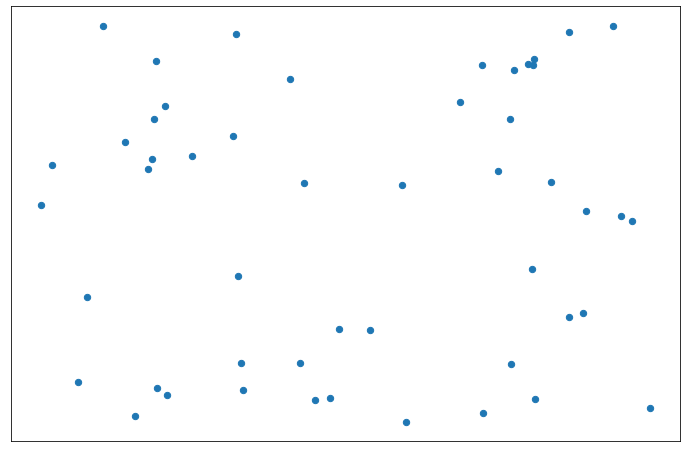

In [50]:
# initialize the environment
env = TSP()

env.reset()

env.render()


In [51]:
next_state, reward, done, _ = env.step(20)

print(next_state, reward, done)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0] 0.4293564334120111 False
